### Example benchmarking comparison between 2 Qiskit transpilers


In [25]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [26]:
from transpile_benchy.interfaces.qasm_interface import QASMBench

qasm_bench = QASMBench(size="medium")
# print(qasm_bench)  # list of names of all possible circuits for qasm

In [27]:
from transpile_benchy.metrics.gate_counts import DepthMetric, TotalMetric

depth_metric = DepthMetric()
total_metric = TotalMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_heavy_hex(5)

In [28]:
from transpile_benchy.passmanagers.qiskit_baseline import QiskitBaseline

baseline1 = QiskitBaseline(optimization_level=1, coupling_map=coupling_map)
baseline2 = QiskitBaseline(optimization_level=2, coupling_map=coupling_map)
baseline3 = QiskitBaseline(optimization_level=3, coupling_map=coupling_map)

In [29]:
benchmark = Benchmark(
    transpilers=[baseline1, baseline2, baseline3],
    metrics=[depth_metric, total_metric],
    submodules=[qasm_bench],  # FIXME, use Library
    logger=transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...
Running circuits for QASMBench:   0%|          | 0/17 [00:00<?, ?it/s]

Running circuits for QASMBench: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]


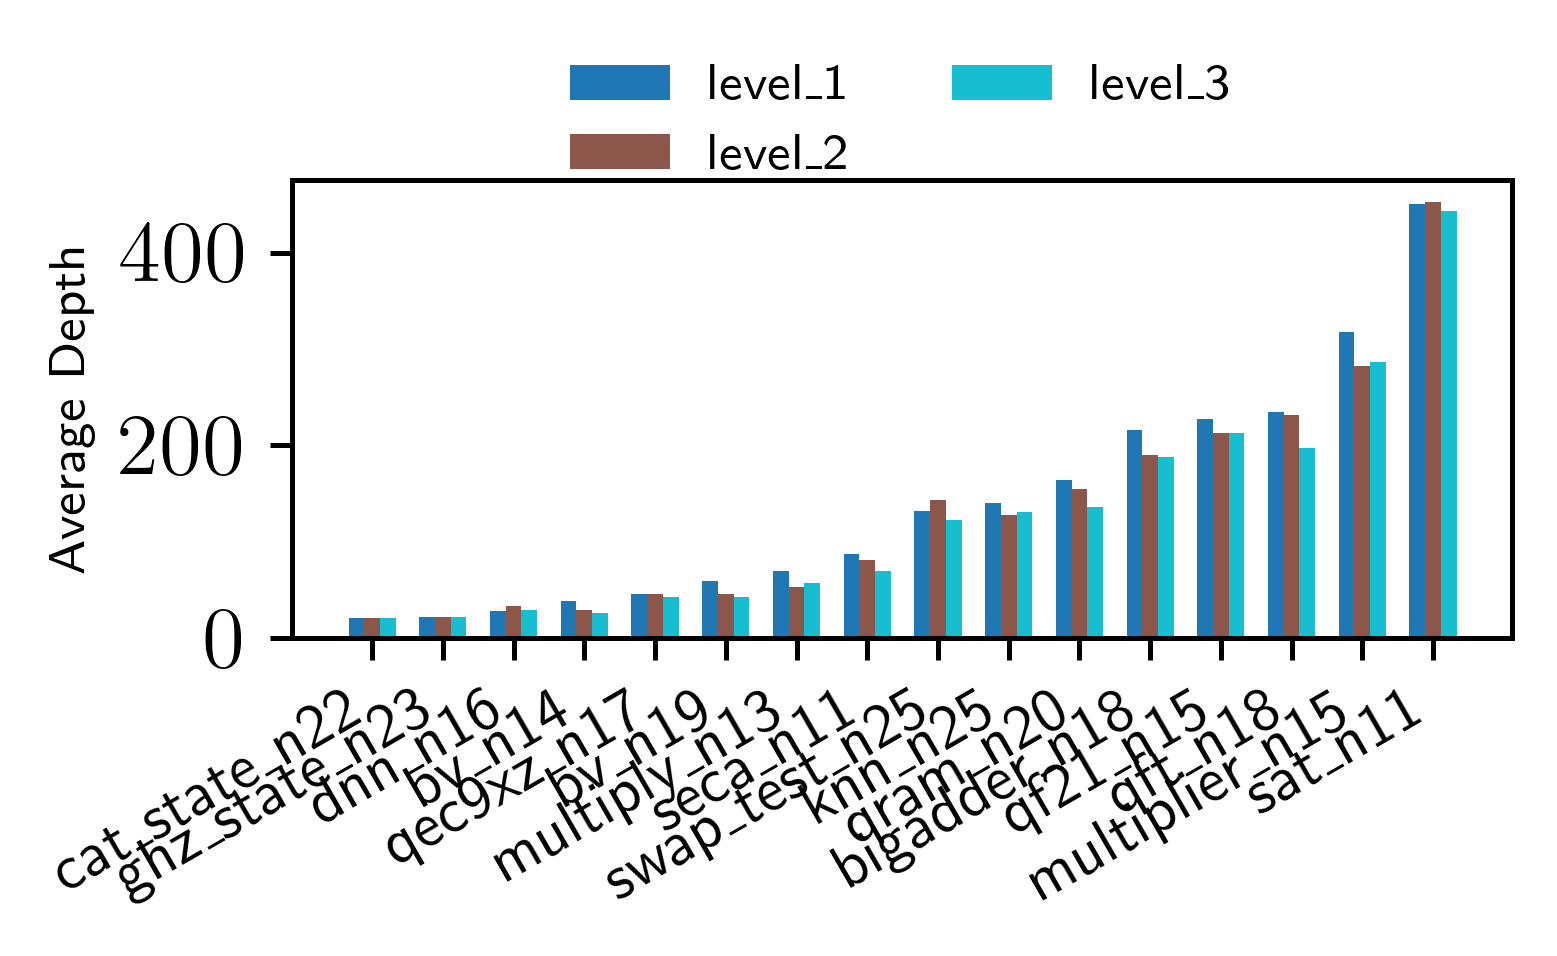

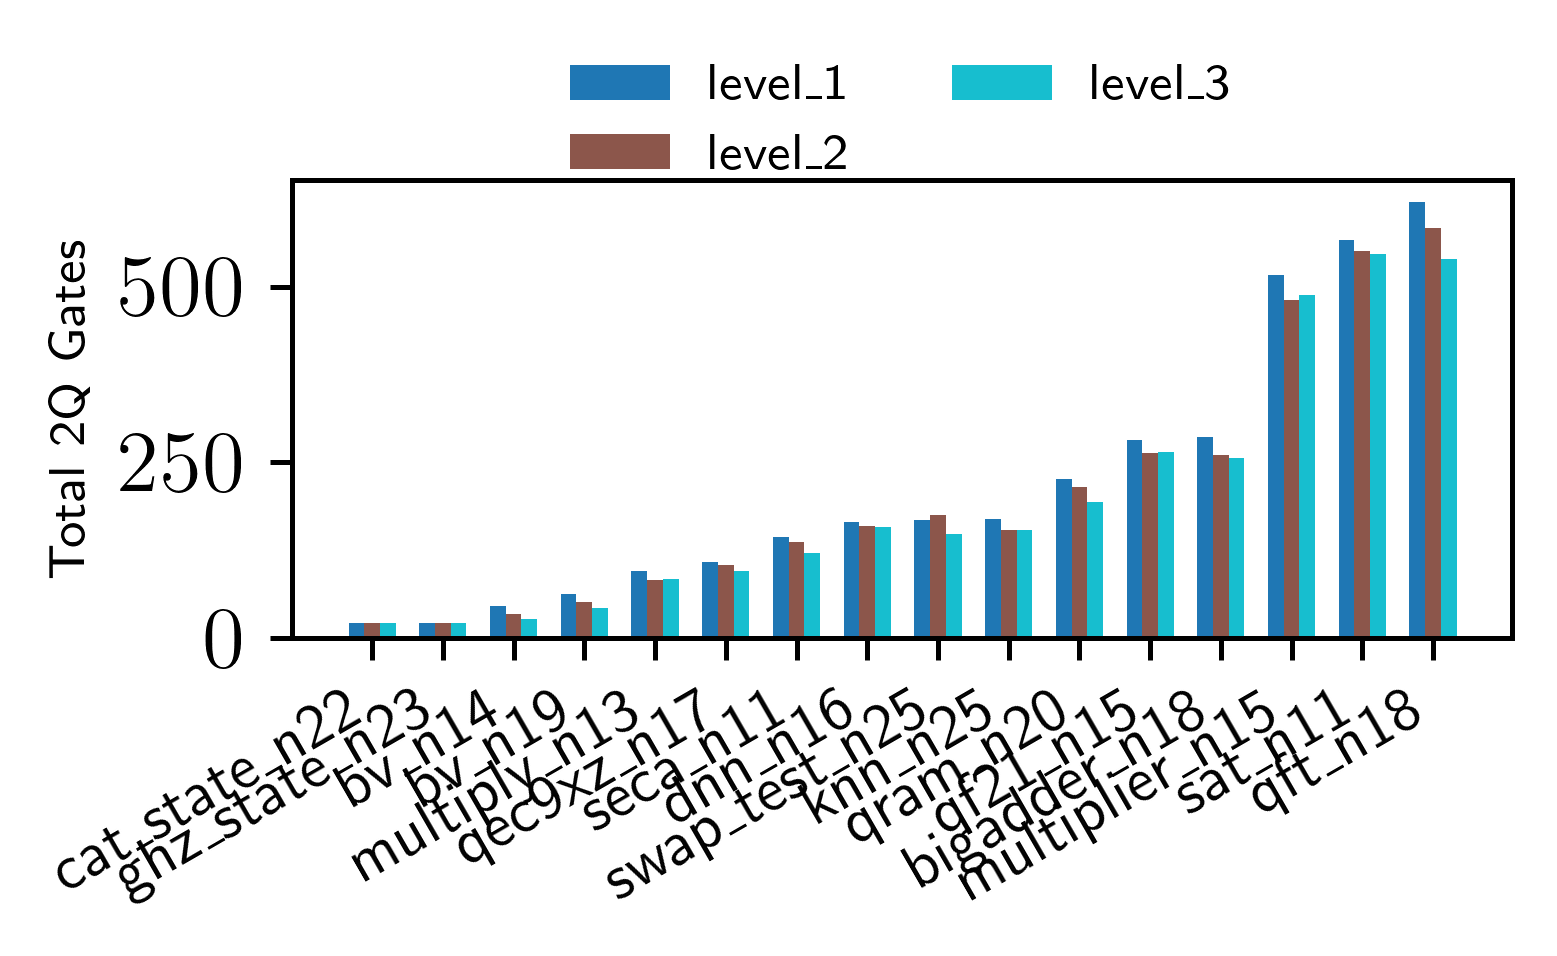

In [31]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(benchmark)